In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from itertools import product

# Data preparation

### Data cleaning

In [ ]:
from data.data_cleaning import clean_sessions_jsonl

clean_sessions_jsonl('data_files/tracks.jsonl', 'data_files/sessions.jsonl', 'data_files/sessions_clean.jsonl')

### Data split

In [3]:
from data.data_split import split_data

sessions_df = pd.read_json('data_files/sessions_clean.jsonl', lines=True)
train_data_df, val_data_df, test_data_df = split_data(sessions_df)

### Interaction Score Aggregation

In this step, we transform raw user-track interaction events into aggregated scores that will be used for matrix factorization. The transformation process:

1. Groups all events by unique user-track pairs
2. Calculates a single interaction score for each pair based on event types:
  - 'like' events contribute 1.0 to the score
  - 'play' events contribute 1.0 to the score
  - 'skip' events and other events contribute 0.0

This converts sequential interaction logs (with timestamps and session IDs) into a format suitable for collaborative filtering - where each user-track pair has a single numerical score representing the user's overall interest level in that track. These scores will be used to train the matrix factorization model.

In [4]:
from data.data_transforming import aggregate_interactions

train_data_aggregated_df = aggregate_interactions(train_data_df)
val_data_aggregated_df = aggregate_interactions(val_data_df)
test_data_aggregated_df = aggregate_interactions(test_data_df)

### Saving the datasets for further use

In [5]:
train_data_aggregated_df.to_json('data_files/train_sessions.jsonl', orient='records', lines=True)
val_data_aggregated_df.to_json('data_files/val_sessions.jsonl', orient='records', lines=True)
test_data_aggregated_df.to_json('data_files/test_sessions.jsonl', orient='records', lines=True)

### Loading the preprocessed training and validation session data from JSON files

In [9]:
sessions_train_df = pd.read_json('data_files/train_sessions.jsonl', lines=True)

In [3]:
sessions_val_df = pd.read_json('data_files/val_sessions.jsonl', lines=True)

# Basic model

The basic model follows a straightforward approach to generate group recommendations: for each user in the group, it identifies their top 50 most played tracks based on historical listening data. It then combines these tracks across all group members and prioritizes songs that appear in multiple users' top tracks. When recommending N tracks, the algorithm first selects songs that are popular among the most group members, then fills any remaining slots randomly from the combined pool of top tracks.

## Model building

In [4]:
from service.core.basic_model import BasicModel

In [5]:
basic_model = BasicModel('data_files/train_sessions.jsonl')

## Model evaluation

1. Relevant Tracks:
    - For a user group, get all tracks from validation set where:
      * track was listened to by ANY user from the group
      * interaction score >= 1.0

2. Precision Calculation:
    precision = (number of recommended tracks that appear in relevant tracks) / (total recommendations)
    
    Example: If 3 out of 10 recommended tracks were listened to by any group 
    member in validation set, precision = 0.3 (30%)

3. Final Metrics:
    - Calculate for different recommendation sizes (5, 10, 30 tracks)
    - Take 10 random groups of 5 users each
    - Report mean precision and standard deviation for each size

In [21]:
from typing import List, Dict, Set, Tuple

def get_group_relevant_tracks(val_df: pd.DataFrame, 
                            user_ids: List[int],
                            relevance_threshold: float = 1.0) -> Set[int]:
    relevant_interactions = val_df[
        (val_df['user_id'].isin(user_ids)) & 
        (val_df['score'] >= relevance_threshold)
    ]
    return set(relevant_interactions['track_id'].unique())

def calculate_group_precision(predicted_tracks: List[str],
                          relevant_tracks: Set[int]) -> float:
    predicted_set = set(predicted_tracks)
    true_positives = len(relevant_tracks.intersection(predicted_set))
    
    return true_positives / len(predicted_set) if predicted_set else 0.0

def evaluate_model_groups(model,
                        val_df: pd.DataFrame,
                        n_groups: int = 10,
                        group_size: int = 5,
                        n_recommendations: List[int] = [5, 10, 30],
                        relevance_threshold: float = 1.0) -> Dict:
    metrics = {n: [] for n in n_recommendations}
    
    all_users = val_df['user_id'].unique().tolist()
    for _ in range(n_groups):
        group_users = np.random.choice(all_users, size=group_size, replace=False)
        
        relevant_tracks = get_group_relevant_tracks(
            val_df, group_users, relevance_threshold
        )
        
        if not relevant_tracks:
            continue
            
        for n in n_recommendations:
            recs = model.get_recommendations(
                [str(uid) for uid in group_users], 
                n
            )
            recs = [track_id for track_id in recs]
            
            precision = calculate_group_precision(recs, relevant_tracks)
            metrics[n].append(precision)
    
    return metrics

def print_group_metrics(metrics: Dict, n_recommendations: List[int]) -> None:
    print("\nGroup Recommendations Performance:")
    print("-" * 50)
    
    for n in n_recommendations:
        print(f"\nPrecision@{n}: {np.mean(metrics[n]):.3f} ± {np.std(metrics[n]):.3f}")

## Model Performance Evaluation Results

In [7]:
group_metrics_for_basic_model = evaluate_model_groups(
    basic_model,
    sessions_val_df,
    n_groups=10,
    group_size=5,
    n_recommendations=[5, 10, 30]
)

print_group_metrics(group_metrics_for_basic_model, [5, 10, 30])


Group Recommendations Performance:
--------------------------------------------------

Precision@5: 0.145 ± 0.131

Precision@10: 0.152 ± 0.094

Precision@30: 0.177 ± 0.105


### Unique User-Track Combinations In Validation Set
Our basic model can only recommend tracks users have already listened to, which is a significant limitation since 75.43% of user-track interactions in the validation set are completely new combinations not present in the training data.

In [8]:
train_combinations = set(zip(sessions_train_df['user_id'], sessions_train_df['track_id']))
val_combinations = set(zip(sessions_val_df['user_id'], sessions_val_df['track_id']))

unique_to_val = val_combinations - train_combinations

print(f"{len(unique_to_val)/len(val_combinations)*100:.2f}% of user-track pairs in the validation set are not present in the training set")

75.43% of user-track pairs in the validation set are not present in the training set


## Basic Model Evaluation Summary
Looking at the basic model's performance metrics, the results are surprisingly decent given that the model simply recommends tracks that group members have previously listened to, without any predictive capabilities.
This is particularly interesting considering that 75.43% of user-track interactions in the validation set don't exist in the training data. The relatively good performance despite this limitation suggests that users tend to repeatedly listen to certain tracks over time, making historical listening data a useful signal even without sophisticated prediction mechanisms.
From a business perspective, this simple approach has a key advantage: users are likely to be satisfied when their favorite tracks appear in group playlists. While more sophisticated models might discover new music more effectively, including well-loved tracks from users' listening history can help create a comfortable group listening experience.

# Advanced Model
Advanced Model
The advanced model implements collaborative filtering using matrix factorization (WMF - Weighted Matrix Factorization), which was thoroughly described in Phase 1 of the project.

## Model Initialization

Before working with the WMF model, we need to properly encode user and track IDs. The model uses embedding layers which require continuous zero-based indices (0 to n-1) for lookup operations. Since our dataset contains non-sequential IDs (e.g., user_ids like 1001, 1578, 2403), we use `IDEncoder` object to map them to the required format. The encoders are saved alongside the model to ensure consistent ID mapping between training and inference.

In [6]:
from models.wmf import WMF

### Use when you would like to initialize new model ↓

In [45]:
from data.data_transforming import IDEncoder

users_df = pd.read_json('data_files/users.jsonl', lines=True)
tracks_df = pd.read_json('data_files/tracks.jsonl', lines=True)
user_encoder = IDEncoder()
track_encoder = IDEncoder()
user_encoder.fit(users_df["user_id"].unique().tolist())
track_encoder.fit(tracks_df["id"].unique().tolist())
model = WMF(
     n_users=len(user_encoder), 
     n_items=len(track_encoder), 
     embedding_dim=32, 
     dropout_rate=0.0, 
     init=True, 
     bias=False, 
     sigmoid=False
)

### Use when you would like to load model from file ↓

In [7]:
model_data = torch.load(
    './model_files/wmf_model.pth',
    map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
)
user_encoder = model_data["user_encoder"]
track_encoder = model_data["track_encoder"]
config = model_data["model_config"]
model = WMF(
    n_users=len(user_encoder),
    n_items=len(track_encoder),
    embedding_dim=config["embedding_dim"],
    dropout_rate=config["dropout_rate"],
    bias=config["bias"],
    sigmoid=config["sigmoid"],
    init=False
)
model.load_state_dict(model_data["model_state_dict"])

<All keys matched successfully>

### Using our previously created encoders to transform user and track IDs into continuous zero-based indices required by the embedding layers

In [10]:
sessions_train_df["user_id"] = user_encoder.encode(sessions_train_df["user_id"].tolist())
sessions_train_df["track_id"] = track_encoder.encode(sessions_train_df["track_id"].tolist())
sessions_val_df["user_id"] = user_encoder.encode(sessions_val_df["user_id"].tolist())
sessions_val_df["track_id"] = track_encoder.encode(sessions_val_df["track_id"].tolist())

### Generating Complete User-Track Interaction Matrix

We create a complete interaction matrix using a subset of users (IDs 2000-2499) and all tracks. We take only a subset of users to reduce training time. First, we generate all possible user-track pairs using cartesian product, then merge this with our existing interaction data, filling missing scores with zeros (indicating no interaction).

In [12]:
from itertools import product

users_range = np.arange(2000, 2500)
tracks_range = np.arange(len(track_encoder))
df = pd.DataFrame(
    product(users_range, tracks_range),
    columns=['user_id', 'track_id']
)

sessions_train_df = df.merge(
    sessions_train_df[['user_id', 'track_id', 'score']],
    on=['user_id', 'track_id'],
    how='left'
).fillna(0)

sessions_val_df = df.merge(
    sessions_val_df[['user_id', 'track_id', 'score']],
    on=['user_id', 'track_id'], 
    how='left'
).fillna(0)

### Calculating Preferences and Confidence Weights

Following the collaborative filtering algorithm, we transform each user-track interaction into two values:

1. Preference:
  - Set to 1 if score ≥ 1 (user interacted positively with track)
  - Set to 0 if score = 0 (no interaction)

2. Confidence Weight:
  - Calculated using the formula: 1 + α * log(1 + score/ε)
  - Where:
    - α (alpha) = 40: hyperparameter controlling confidence scaling
    - ε (epsilon) = 1e-8: small constant to prevent log(0)
  - Higher interaction scores result in higher confidence values

These values are then used in the model's objective function:

$$
\min_{x,y} \sum_{u,i} c_{ui}(p_{ui} - x_u^Ty_i)^2 + \lambda(\sum_u ||x_u||^2 + \sum_i ||y_i||^2)
$$

where:
- $c_{ui}$: confidence weight for interaction between user $u$ and track $i$
- $p_{ui}$: preference value (0 or 1) for user $u$ and track $i$
- $x_u$: embedding vector for user $u$
- $y_i$: embedding vector for track $i$
- $x_u^Ty_i$: dot product of user and track embeddings (predicted preference)
- $\lambda$: regularization parameter controlling the strength of regularization
- $||x_u||^2$, $||y_i||^2$: L2 norms of embedding vectors (regularization terms)

In our implementation, we use L2 regularization through the AdamW optimizer's weight decay parameter, which achieves the same effect of preventing overfitting by penalizing large embedding values.

In [13]:
sessions_train_df['preference'] = sessions_train_df['score'] >= 1
sessions_val_df['preference'] = sessions_val_df['score'] >= 1

In [14]:
alpha = 40
epsilon = 1e-8
sessions_train_df['weight'] = 1 + alpha * np.log(1 + sessions_train_df['score'] / epsilon)
sessions_val_df['weight'] = 1 + alpha * np.log(1 + sessions_val_df['score'] / epsilon)

### Training

In [15]:
train_dataset = torch.utils.data.TensorDataset(
    torch.LongTensor(sessions_train_df['user_id'].values),
    torch.LongTensor(sessions_train_df['track_id'].values),
    torch.FloatTensor(sessions_train_df['preference'].values),
    torch.FloatTensor(sessions_train_df['weight'].values)
)

val_dataset = torch.utils.data.TensorDataset(
    torch.LongTensor(sessions_val_df['user_id'].values),
    torch.LongTensor(sessions_val_df['track_id'].values),
    torch.FloatTensor(sessions_val_df['preference'].values),
    torch.FloatTensor(sessions_val_df['weight'].values)
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=512,
    shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=512,
    shuffle=False
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
from models.training import Trainer

trainer = Trainer(model, train_loader, val_loader, device)
train_loss, val_loss = trainer.train_with_weight_decay(
    epochs=15,
    learning_rate=0.005,
    weight_decay=0.005
)

KeyboardInterrupt: 

In [9]:
trainer = Trainer(model, train_loader, val_loader, device)
train_loss, val_loss = trainer.train_with_weight_decay(
    epochs=15,
    learning_rate=0.005,
    weight_decay=0.005
)

Epoch: 0; Train loss: 2.1193120233908957; Val loss: 0.7193592203457703
Epoch: 1; Train loss: 1.6375799859123472; Val loss: 0.7103575413768615
Epoch: 2; Train loss: 1.6198288817497366; Val loss: 0.7013339042746465
Epoch: 3; Train loss: 1.6090435236331593; Val loss: 0.7218749337733186
Epoch: 4; Train loss: 1.621430717675199; Val loss: 0.7044596232173183
Epoch: 5; Train loss: 1.6071691410641997; Val loss: 0.7012811195634313


KeyboardInterrupt: 

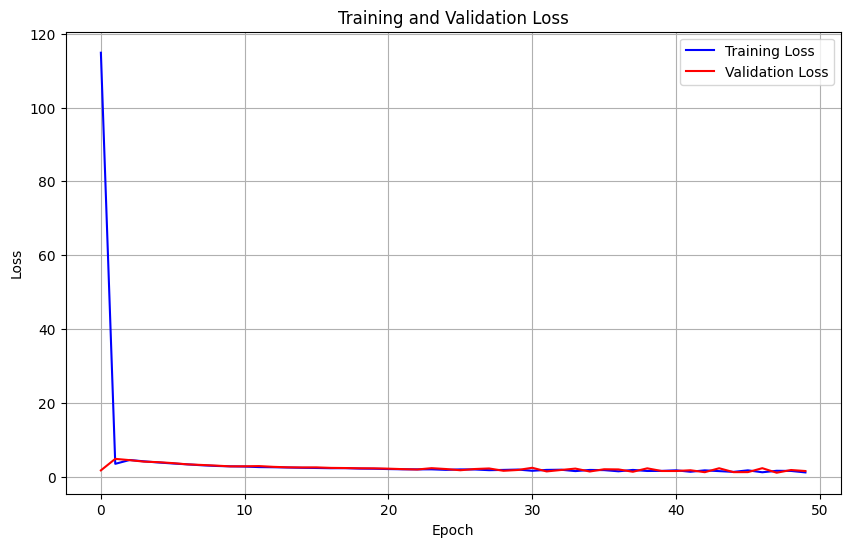

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(train_loss, 'b-', label='Training Loss')
plt.plot(val_loss, 'r-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

### Training Results Analysis

The training process shows an interesting and unusual pattern where the validation loss is consistently lower than the training loss. After multiple code reviews and verifications of the implementation, we couldn't identify any bugs that would cause this behavior.

This counterintuitive result might be explained by the data characteristics of our problem:
1. We're training on all tracks from tracks.json, but users interacted with only a small subset of them (this will be explored later)
2. This creates a highly sparse interaction matrix with many zero values
3. Combined with:
  - The large number of model parameters (embeddings for all users and tracks)
  - Relatively small amount of actual interaction data
  - The complexity of gradient descent optimization
  
This sparsity and parameter-to-data ratio could potentially lead to this unusual loss pattern. However, without further investigation, we cannot make a definitive conclusion about the cause of this behavior.

### Regularization Analysis

To verify if our model's regularization is working correctly, we examined the norms of the learned embeddings:
- Average user embedding norm: 0.34
- Average item embedding norm: 0.98

These values indicate that the regularization (implemented through AdamW's weight decay) is effectively preventing the embeddings from growing too large. This suggests that the unusual training/validation loss pattern is not caused by insufficient regularization, and we should look for other explanations in the data characteristics and model architecture.

In [17]:
user_norms = torch.norm(model.user_embedding.weight, dim=1)
avg_user_norm = torch.mean(user_norms) 
item_norms = torch.norm(model.item_embedding.weight, dim=1)
avg_item_norm = torch.mean(item_norms)

print("Average user embedding norm:", avg_user_norm.item())
print("Average item embedding norm:", avg_item_norm.item())

Average user embedding norm: 0.31869420409202576
Average item embedding norm: 0.9587802886962891


### Saving the model to a file

In [60]:
checkpoint = {
    'model_state_dict': model.state_dict(),
    'model_config': {
        'embedding_dim': model.user_embedding.embedding_dim,
        'dropout_rate': model.dropout.p,
        'bias': model.bias,
        'sigmoid': model.sigmoid,
    },
    'user_encoder': user_encoder,
    'track_encoder': track_encoder
}

torch.save(checkpoint, './model_files/wmf_model.pth')

# Evaluation

### Preparing Evaluation Data

For evaluation purposes, we select a random subset of 50 users. For these users, we generate all possible user-track pairs to evaluate how well our model ranks all available tracks for each user.

The process involves several steps:
1. Select 50 random users from our user base using numpy's random choice function
2. Create a cartesian product of these users with all available tracks in our dataset
3. Merge this complete set of user-track pairs with our validation data (which contains actual user interactions)
4. Fill missing values with 0 (representing no interaction)

This approach assumes that the validation data (`sessions_val_df`) has already been aggregated using the `aggregate_interactions` function, which was done in the data preparation step

In [11]:
random_ids = np.random.choice(len(user_encoder), size=50, replace=False)
users = np.array(random_ids)
tracks = np.arange(len(track_encoder))
df = pd.DataFrame(
    product(users, tracks),
    columns=['user_id', 'track_id']
)

sessions_val_df = df.merge(
    sessions_val_df[['user_id', 'track_id', 'score']],
    on=['user_id', 'track_id'], 
    how='left'
).fillna(0)

## Model Performance Evaluation Results

In [12]:
val_dataset = torch.utils.data.TensorDataset(
    torch.LongTensor(sessions_val_df['user_id'].values),
    torch.LongTensor(sessions_val_df['track_id'].values),
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=512,
    shuffle=False
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
from prediction.predict import predict
sessions_val_df['score_pred'] = predict(model, val_loader, device)

In [14]:
k_list = [5, 10, 30]

from evaluation.evaluator import Evaluator
evaluator = Evaluator(k_list, 2.0)

In [15]:
metrics = evaluator.evaluate(sessions_val_df)

## Overall Model Performance
Looking at the mean metric values, we can see that the model performs only slightly better than random recommendations. 

In [16]:
from evaluation.metrics import print_metrics
print_metrics(metrics, k_list)


Model Performance Metrics:

Metrics for top-5 recommendations:
-----------------------------------
NDCG       =   8.00% ±  15.26%
Precision  =  10.80% ±  27.47%
Recall     =   0.89% ±   2.09%

Metrics for top-10 recommendations:
-----------------------------------
NDCG       =   8.01% ±  14.80%
Precision  =   9.60% ±  23.38%
Recall     =   1.46% ±   3.22%

Metrics for top-30 recommendations:
-----------------------------------
NDCG       =   8.62% ±  14.76%
Precision  =   8.27% ±  19.51%
Recall     =   5.00% ±  10.60%


## Per user metrics display

To investigate model performance, we displayed metrics for each individual user. The results showed that most users had metrics equal to zero, while a few users (e.g., user 979 with NDCG@5 = 0.619 and Precision@5 = 1.0) showed exceptionally high performance. This interesting pattern led us to investigate further.

In [17]:
metrics_df = pd.DataFrame()
for k in k_list:
    metrics_df[f'NDCG@{k}'] = metrics[f'NDCG@{k}']
    metrics_df[f'Precision@{k}'] = metrics[f'Precision@{k}']
    metrics_df[f'Recall@{k}'] = metrics[f'Recall@{k}']
display(metrics_df)

,NDCG@5,Precision@5,Recall@5,NDCG@10,Precision@10,Recall@10,NDCG@30,Precision@30,Recall@30
user_id,,,,,,,,,
92,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.025058,0.000000,0.000000
96,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
160,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.012348,0.000000,0.000000
191,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
210,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.019045,0.000000,0.000000
340,0.000000,0.0,0.000000,0.065225,0.1,0.015625,0.075198,0.100000,0.046875
441,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.012425,0.000000,0.000000
512,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
538,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000


### Analysis of Model Performance Variations
We compared two users - one with high metrics (user_id 1101) and one with zero metrics (user_id 1625) - to understand why only a few users had high metric scores. Our analysis revealed that for users with high metrics, the tracks they listened to in the validation set were also present in their training set interactions. For users with zero metrics, there was little to no overlap between their training and validation tracks.

In [18]:
merged_df = sessions_val_df.merge(
    sessions_train_df, 
    on=['user_id', 'track_id'], 
    how='right',
    suffixes=('_val', '_train')
)

for user_id in [1101, 1625]:
    print(f"\nUser {user_id}:")
    user_data = merged_df[merged_df['user_id'] == user_id]
    print(f"Sum of score_val: {user_data['score_val'].sum()}")
    print(f"Sum of score_train: {user_data['score_train'].sum()}")


User 1101:
Sum of score_val: 555.0
Sum of score_train: 1225

User 1625:
Sum of score_val: 10.0
Sum of score_train: 280


## Training Data Sparsity Analysis
The heatmap visualization of user-track interactions reveals a critical limitation in our training data: users only interacted with a very narrow range of tracks (visible as sparse vertical green bands), while the vast majority of tracks had very low or zero interaction counts (dark purple regions).
This extreme sparsity is particularly problematic because our model attempts to learn embeddings for all tracks present in tracks.json, regardless of their interaction count. During gradient descent optimization, we're trying to learn meaningful representations for thousands of tracks based on extremely limited interaction data. With such sparse information spread across such a large parameter space (embeddings for all tracks), the model struggles to learn meaningful patterns that would generalize well to recommendations.

In [ ]:
import seaborn as sns

heatmap_data = sessions_train_df.pivot_table(
    values='score',
    index='user_id',
    columns='track_id',
    aggfunc='mean',
    fill_value=0
)

plt.figure(figsize=(15, 10))
plt.pcolormesh(heatmap_data, cmap='viridis')
plt.colorbar(label='Score')
plt.title('Heatmap of User-Track Scores')
plt.xlabel('Track ID')
plt.ylabel('User ID')

plt.xticks(np.arange(0, len(heatmap_data.columns), 100), 
          heatmap_data.columns[::100], 
          rotation=45)
plt.yticks(np.arange(0, len(heatmap_data.index), 100), 
          heatmap_data.index[::100])

plt.tight_layout()

plt.show()

## Model Performance Analysis Conclusion

During consulations, we identified two likely reasons for the model's poor performance:

Our training dataset (~500MB) was several orders of magnitude smaller than what's typically needed for effective collaborative filtering (tens of gigabytes)
The extreme sparsity of user-track interactions, where we attempted to learn embeddings for all tracks in tracks.json despite most tracks having very few interactions (many have zero interactions)

These limitations likely prevented the model from learning meaningful user and track embeddings, explaining why most users had near-zero performance metrics except for a few cases where there was substantial overlap between training and validation interactions.

# Comparison of Basic Model to advanced model

In [19]:
sessions_val_df["user_id"] = user_encoder.decode(sessions_val_df["user_id"].tolist())
sessions_val_df["track_id"] = track_encoder.decode(sessions_val_df["track_id"].tolist())

In [22]:
from service.core.advanced_model import AdvancedModel
advanced_model = AdvancedModel('model_files/wmf_model.pth')
basic_model = BasicModel('data_files/train_sessions.jsonl')

group_metrics_for_basic_model = evaluate_model_groups(
    basic_model,
    sessions_val_df,
    n_groups=100,
    group_size=5,
    n_recommendations=[5, 10, 30]
)

group_metrics_for_advanced_model = evaluate_model_groups(
    advanced_model,
    sessions_val_df,
    n_groups=100,
    group_size=5,
    n_recommendations=[5, 10, 30]
)

print_group_metrics(group_metrics_for_basic_model, [5, 10, 30])
print_group_metrics(group_metrics_for_advanced_model, [5, 10, 30])


Group Recommendations Performance:
--------------------------------------------------

Precision@5: 0.265 ± 0.241

Precision@10: 0.294 ± 0.231

Precision@30: 0.454 ± 0.348

Group Recommendations Performance:
--------------------------------------------------

Precision@5: 0.264 ± 0.306

Precision@10: 0.231 ± 0.283

Precision@30: 0.198 ± 0.280


Looking at the performance metrics of both models, we can observe that the basic model slightly outperforms the advanced model.

The basic model's better performance can be attributed to its deterministic nature - when a user in the validation set has listened to the same tracks as in the training set, the basic model will never make a mistake in recommendations. It simply recommends the tracks that the user has already shown interest in, which is a reliable strategy when historical patterns repeat.

However, it's important to note that both models are primarily successful in cases where users in the validation set interact with the same tracks they previously interacted with in the training set. The basic model explicitly uses this historical interaction data, while the advanced model, despite its more sophisticated matrix factorization approach, is limited by the small training dataset and therefore also relies heavily on existing user-track interactions.

If we were to train the advanced model on a significantly larger dataset (in the order of tens of gigabytes rather than the current ~500MB), we would expect to see much better performance compared to the basic model. This is because with more data, the matrix factorization model would be able to learn meaningful user and track embeddings, enabling it to identify patterns and similarities that go beyond simple historical interactions. This would allow the advanced model to make relevant recommendations even for tracks that users haven't previously interacted with, something the basic model fundamentally cannot do.

In essence, while the basic model performs slightly better with the current limited dataset due to its deterministic nature with repeated interactions, the advanced model has the potential to significantly outperform the basic approach given sufficient training data.